Experiement Sampling

In [591]:
import pandas as pd
import numpy as np
import faker
import scipy
import scipy.stats as stats
from scipy.stats import chi2
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.pyplot as plt
import math
import researchpy as rp
import seaborn as sns
from scipy.stats import chi2
from sklearn.cluster import KMeans

Create a dummy sample data set

In [592]:
fake = faker.Faker()

# function to create a dataframe with fake values for our workers
def create_agents(n1, n2, n3, n4, n5):

    def PosNormal(mean, sigma):
      x = np.random.normal(mean,sigma,1)
      return(x if x>=0 else PosNormal(mean,sigma))

    list_1 = [{'Agent ID': x + 1000
                , 'Agent Name': fake.name()
                , 'Number of calls': int(PosNormal(50, 1000)) # customer calls received between 0 and 2000, uniform dist
                , 'Disatisfication Rate': float(PosNormal(0.4,0.05)), # complaint rate between 0 and 50%, uniform dist.
                  } for x in range(n1)
            ]

    list_2 = [{'Agent ID': x + 1000 + n1
                , 'Agent Name': fake.name()
                , 'Number of calls': int(PosNormal(1000, 500)) # customer calls received between 0 and 2000, uniform dist
                , 'Disatisfication Rate': float(PosNormal(0.2,0.05)), # complaint rate between 0 and 50%, uniform dist.
                  } for x in range(n2)
            ]
    
    list_3 = [{'Agent ID': x + 1000 + n1 + n2
            , 'Agent Name': fake.name()
            , 'Number of calls': int(PosNormal(1500, 500)) # customer calls received between 0 and 2000, uniform dist
            , 'Disatisfication Rate': float(PosNormal(0.1,0.05)), # complaint rate between 0 and 50%, uniform dist.
              } for x in range(n3)
            ]

    list_4 = [{'Agent ID': x + 1000 + n1 + n2 + n3
            , 'Agent Name': fake.name()
            , 'Number of calls': int(PosNormal(3000, 500)) # customer calls received between 0 and 2000, uniform dist
            , 'Disatisfication Rate': float(PosNormal(0.05,0.05)), # complaint rate between 0 and 50%, uniform dist.
              } for x in range(n4)
            ]

   # create outliers         

    list_5 = [{'Agent ID': x + 1000 + n1 + n2+ n3 + n4
            , 'Agent Name': fake.name()
            , 'Number of calls': int(PosNormal(500, 1000)) # customer calls received between 0 and 2000, uniform dist
            , 'Disatisfication Rate': float(PosNormal(0.65,0.02)), # complaint rate between 0 and 50%, uniform dist.
              } for x in range(n5)
            ]

    list_6 = [{'Agent ID': x + 1000 + n1 + n2 + n3 + n4 + n5
            , 'Agent Name': fake.name()
            , 'Number of calls': int(PosNormal(5, 500)) # customer calls received between 0 and 2000, uniform dist
            , 'Disatisfication Rate': float(PosNormal(0.1,0.05)), # complaint rate between 0 and 50%, uniform dist.
              } for x in range(n5)
            ]

    list_7 = [{'Agent ID': x + 1000 + n1 + n2 + n3 + n4 + n5 * 2
            , 'Agent Name': fake.name()
            , 'Number of calls': int(PosNormal(3000, 500)) # customer calls received between 0 and 2000, uniform dist
            , 'Disatisfication Rate': float(PosNormal(0.1,0.05)), # complaint rate between 0 and 50%, uniform dist.
              } for x in range(n5)
            ]

    list_8 = [{'Agent ID': x + 1000 + n1 + n2 + n3 + n4 + n5 * 3
            , 'Agent Name': fake.name()
            , 'Number of calls': int(PosNormal(3000, 500)) # customer calls received between 0 and 2000, uniform dist
            , 'Disatisfication Rate': float(PosNormal(0.5,0.1)), # complaint rate between 0 and 50%, uniform dist.
              } for x in range(n5)
            ]

    agents = list_1 + list_2 + list_3 + list_4 + list_5 + list_6 + list_7 + list_8
  
    return agents

df_agent = pd.DataFrame(create_agents(n1 = 170, n2 = 150, n3 = 300, n4 = 300, n5 = 20))

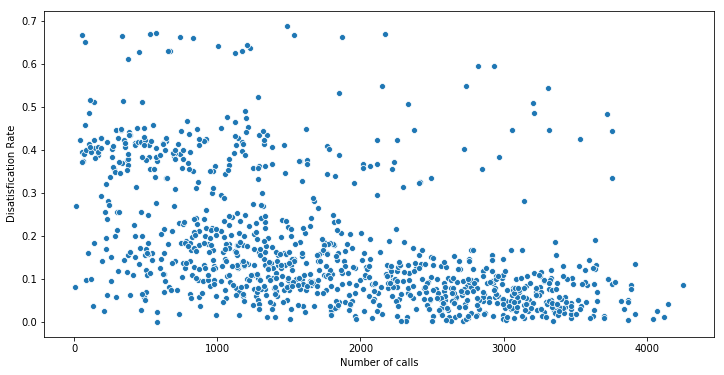

In [593]:
# plot outliers chart
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_agent, x="Number of calls", y="Disatisfication Rate")

In [594]:
print(df_agent.head().to_markdown())

|    |   Agent ID | Agent Name      |   Number of calls |   Disatisfication Rate |
|---:|-----------:|:----------------|------------------:|-----------------------:|
|  0 |       1000 | Patrick Wiggins |                54 |               0.394775 |
|  1 |       1001 | Paul Willis     |              1069 |               0.476513 |
|  2 |       1002 | Angel Bradford  |                64 |               0.389071 |
|  3 |       1003 | Jennifer Valdez |               579 |               0.372736 |
|  4 |       1004 | Sarah Gonzalez  |               424 |               0.416685 |


Calculate Mahalanobis Distance and Remove Outliers

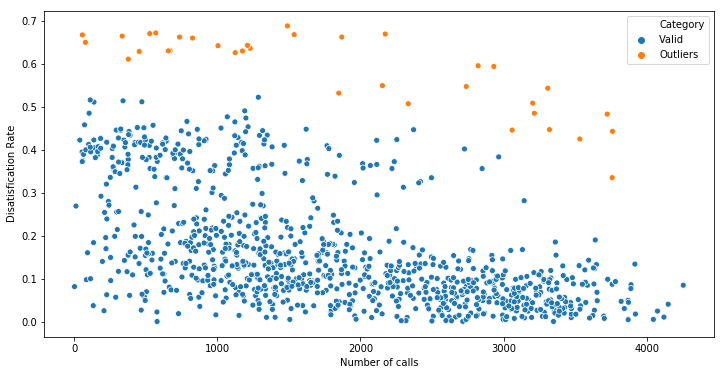

In [595]:
def calculateMahalanobis(y=None, data=None, cov=None):
  
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

# the Mahalanobis distance for each row
df_agent['Mahalanobis'] = calculateMahalanobis(y = df_agent[['Number of calls', 'Disatisfication Rate']], data = df_agent[['Number of calls', 'Disatisfication Rate']])
  
# calculate p-value for each mahalanobis distance
df_agent['p_value'] = 1 - chi2.cdf(df_agent['Mahalanobis'], 3)

# determine p value threshold for outliters
df_agent['Category'] = ['Outliers' if p <= 0.05 else "Valid" for p in df_agent['p_value'].values]

# plot outliers chart
plt.figure(figsize=(12,6))
sns.scatterplot(data = df_agent, x = "Number of calls", y = "Disatisfication Rate", hue = "Category")

In [596]:
df_agent = df_agent[df_agent['Category'] != 'Outliers'].reset_index(drop = False)

Two-stage Sampling:
1. Use K-Mean Method to Find Clusters

In [597]:
x = df_agent['Number of calls']
y = df_agent['Disatisfication Rate']

data = list(zip(x, y))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

c:\Users\litia\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\Users\litia\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\Users\litia\Anaconda3\lib\site-packages\sklearn\metrics\pairw

Use elbow graph to find number of groups (K)

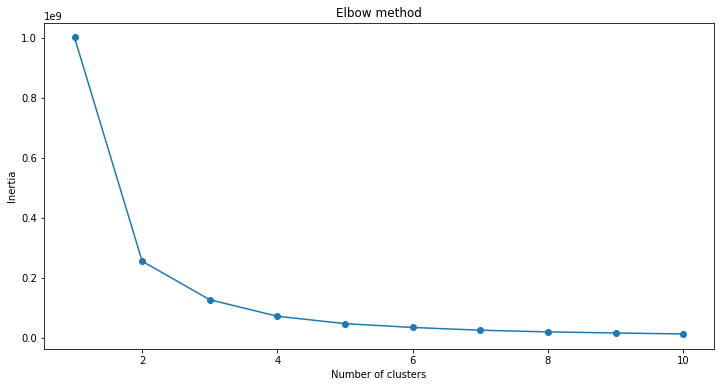

In [598]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [599]:
kmeans = KMeans(n_clusters = 4)
y_kmeans = kmeans.fit(data)
predict = kmeans.predict(data)
df_agent['Cluster'] = pd.Series(predict, index = df_agent.index)

c:\Users\litia\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\Users\litia\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\Users\litia\Anaconda3\lib\site-packages\sklearn\metrics\pairw

In [600]:
y_kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

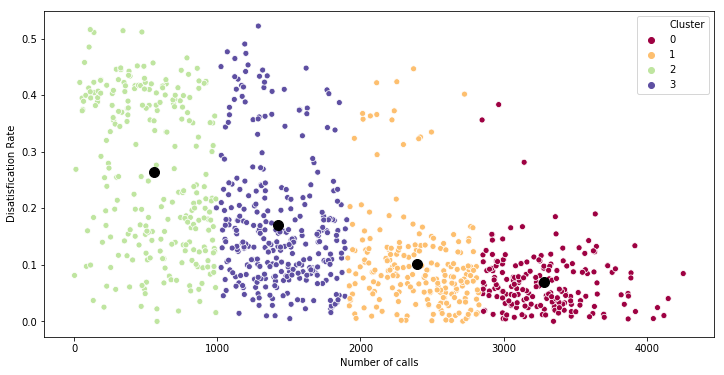

In [601]:
plt.figure(figsize=(12,6))
sns.scatterplot(data = df_agent, x = "Number of calls", y = "Disatisfication Rate", hue = "Cluster",legend= "full", palette="Spectral")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label = 'Centroids')

In [602]:
# drop extra point if not even
def drop_extra_point(df):
    pp_size = df['Agent ID'].count()
    if pp_size % 2 != 0:
        df = df.sample(pp_size - 1)
    else:
        pass

    return df

df_pp = df_agent.groupby(['Cluster']).apply(drop_extra_point).reset_index(drop = True)

2. Sample from each Cluster

In [603]:
def sampling(df):

    n = int(df['Agent ID'].count() / 2)
    df_sample = df.sample(n)

    return df_sample

df_A = df_pp.groupby(['Cluster']).apply(sampling).reset_index(drop = True)


In [604]:
df_A['Group'] = 'Control'
df_B = df_pp[~df_pp['Agent ID'].isin(df_A['Agent ID'])].reset_index(drop = True)
df_B['Group'] = 'Treatment'

In [605]:
df_exp = pd.concat([df_A,df_B]).reset_index(drop = True)

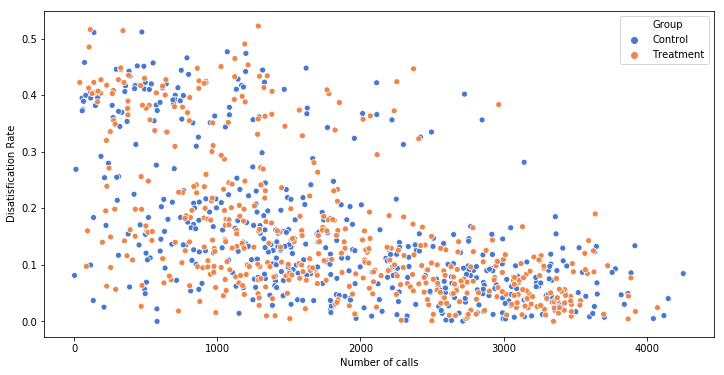

In [606]:
plt.figure(figsize=(12,6))
sns.scatterplot(data = df_exp, x = "Number of calls", y = "Disatisfication Rate", hue = "Group",legend= "full", palette="muted")

Check Balance for A/B Groups

In [607]:
df_exp.groupby('Group')['Disatisfication Rate'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,481.0,0.159433,0.127517,0.000160,0.065155,0.122942,0.210862,0.511506
Treatment,481.0,0.158891,0.128788,0.000346,0.066938,0.110975,0.205169,0.522034


In [608]:
df_exp.groupby('Group')['Number of calls'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,481.0,1793.582121,1026.100954,1.0,971.0,1628.0,2650.0,4256.0
Treatment,481.0,1791.205821,1014.153737,38.0,978.0,1653.0,2657.0,4076.0


In [609]:
# df_exp.groupby('Group')['Disatisfication Rate'].apply(rp.summary_cont)

Check Normality of Sampling Differences

In [610]:
df_A.sort_values(by = 'Disatisfication Rate', ascending = True, inplace = True)
df_B.sort_values(by = 'Disatisfication Rate', ascending = True, inplace = True)

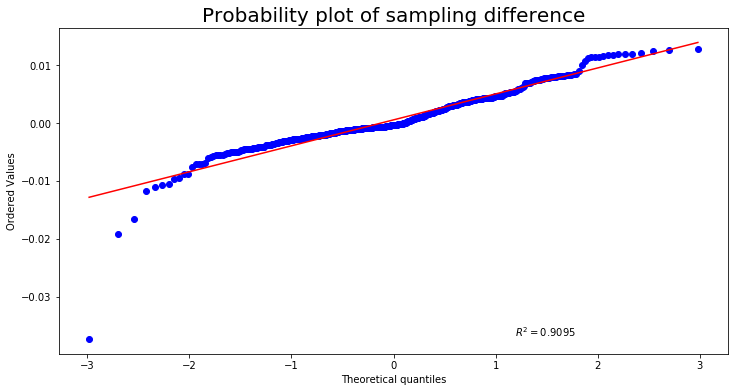

In [611]:
sampling_difference = df_A['Disatisfication Rate'].values - \
                    df_B['Disatisfication Rate'].values

fig = plt.figure(figsize= (12, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [612]:
#perform Kolmogorov-Smirnov test
stats.ks_2samp(df_A['Disatisfication Rate'], df_B['Disatisfication Rate'])

KstestResult(statistic=0.04365904365904366, pvalue=0.7495589610391412)

The two sample K-S test show that p value > 0.05, hence we cannot reject the null hypothesis that the two distributions are identical. 

Test Homogeneity of Variances

In [613]:
stats.levene(df_A['Disatisfication Rate'], df_B['Disatisfication Rate']) # less sensitive to normality

LeveneResult(statistic=0.02776386602352528, pvalue=0.867700267378794)

In [614]:
# stats.bartlett(df_A['Disatisfication Rate'], df_B['Disatisfication Rate']) # if data follow normal distribution

p value of Levene test > 0.05, indicating that the variances between two groups are statistically insignificant.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DDCF929E8>,
      dtype=object)

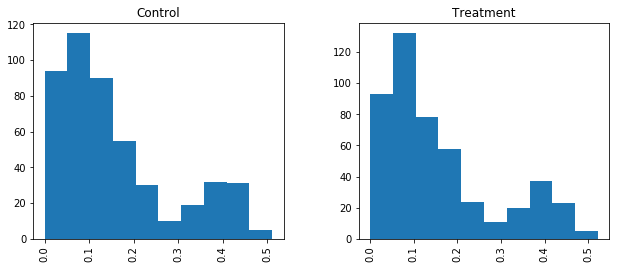

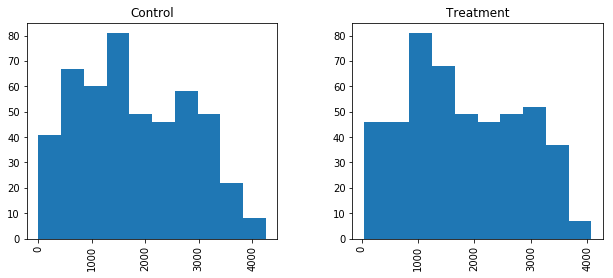

In [615]:
df_exp.hist(by='Group',column='Disatisfication Rate', figsize=[10, 4])
df_exp.hist(by='Group',column='Number of calls', figsize=[10, 4])

Run T-test to Compare Sample Mean

In [616]:
scipy.stats.ttest_ind(df_A['Disatisfication Rate'], df_B['Disatisfication Rate'])

Ttest_indResult(statistic=0.06564236130971243, pvalue=0.9476762292074914)

In [617]:
rp.ttest(group1= df_A['Disatisfication Rate'], group1_name= "Control",
         group2= df_B['Disatisfication Rate'], group2_name= "Treatment")

(    Variable      N      Mean        SD        SE  95% Conf.  Interval
 0    Control  481.0  0.159433  0.127517  0.005814   0.148009  0.170858
 1  Treatment  481.0  0.158891  0.128788  0.005872   0.147353  0.170429
 2   combined  962.0  0.159162  0.128087  0.004130   0.151058  0.167267,
                     Independent t-test   results
 0  Difference (Control - Treatment) =     0.0005
 1                Degrees of freedom =   960.0000
 2                                 t =     0.0656
 3             Two side test p value =     0.9477
 4            Difference < 0 p value =     0.5262
 5            Difference > 0 p value =     0.4738
 6                         Cohen's d =     0.0042
 7                         Hedge's g =     0.0042
 8                    Glass's delta1 =     0.0043
 9                  Point-Biserial r =     0.0021)

Control and treatment groups have similar mean and stdev, p value of t-test > 0.05, indicating the mean of two groups have no statistically significant difference.

In [618]:
# def sampling(df):
	
# 	# calculate Mahalanobis Distance
# 	def mashi_distance(x, y):

# 		X = np.vstack([x,y])		
# 		XT = X.T
		
# 		try:
# 			S = np.cov(X)
# 			SI = np.linalg.inv(S)
# 			n = XT.shape[0]
# 			d1 = []
			
# 			for i in range(0,n):
# 				for j in range(i+1, n):
# 					delta = XT[i] - XT[j]
# 					d = np.sqrt(np.dot(np.dot(delta, SI), delta.T))
# 					d1.append(d)

# 		except:
# 			d1 = [0]
		
# 		return d1
					
# 	agent_cnt = len(df_agent.index)
# 	n1 = math.floor(agent_cnt / 2)
# 	n2 = n1	
	
# 	count = 0
# 	distance1 = [3]
# 	distance2 = [3]
	
# 	while count < 100:
# 		if sum(distance1) / len(distance1) < 1.5 and sum(distance2) / len(distance2) < 1.5:
# 			break
# 		else:
# 			count = count + 1
# 			df1 = df.sample(n = n1)
# 			df2 = df[~df.index.isin(df1.index)]
# 			df2 = df2.sample(n = n2)
			
# 			x_list1 = df1['Compliant Rate'].to_list()
# 			y_list1 = df2['Compliant Rate'].to_list()
		
# 			x_list2 = df1['Customer Calls'].to_list()
# 			y_list2 = df2['Customer Calls'].to_list()
			
# 			distance1 = mashi_distance(x_list1, y_list1)
# 			distance2 = mashi_distance(x_list2, y_list2)
	   
# 	print(count)
	
# 	return df1, df2

# df_treatment = pd.DataFrame()
# df_control = pd.DataFrame()
# df_treatment, df_control = sampling(df_agent)